## Distribution of the inverse index

In [1]:
%matplotlib inline
%load_ext memory_profiler
from neighborsMinHash import MinHash
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
import time

In [2]:
from eden.converter.graph.gspan import gspan_to_eden
from eden.graph import Vectorizer
graphs = gspan_to_eden( 'http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan' )
vectorizer = Vectorizer( r=2,d=5 )
%time %memit datasetBursi = vectorizer.transform( graphs )

peak memory: 277.17 MiB, increment: 183.80 MiB
CPU times: user 17.1 s, sys: 40 ms, total: 17.1 s
Wall time: 18.3 s


In [3]:
n_neighbors_minHash = MinHash(number_of_hash_functions=400, shingle_size = 1, similarity=True, bloomierFilter=False, number_of_cores=2)
n_neighbors_minHash.fit(datasetBursi)

In [4]:
distribution = n_neighbors_minHash.get_distribution_of_inverse_index()
min_ = min(distribution[0])
max_ = max(distribution[0])

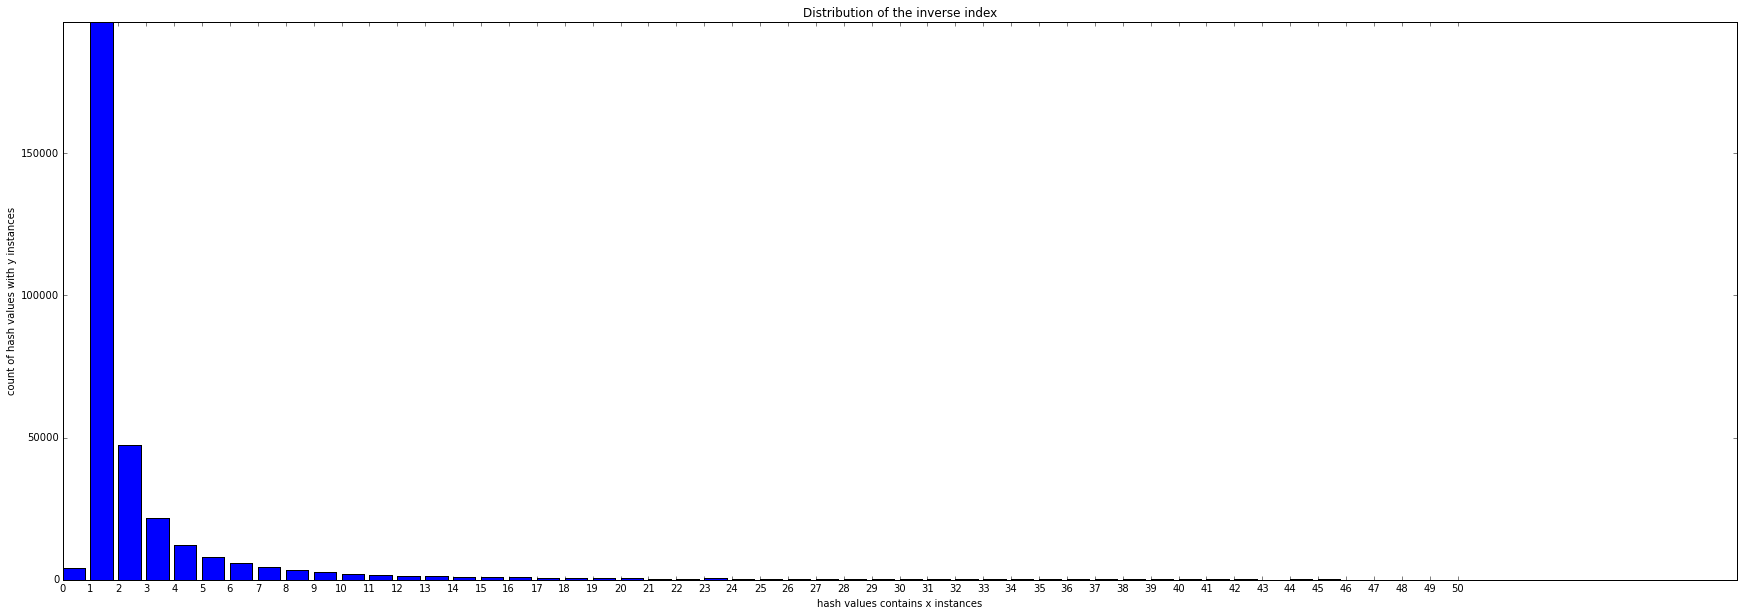

In [5]:
X = np.arange(len(distribution[0]))
plt.figure(figsize=(30, 10))
plt.bar(X, distribution[0].values())
plt.xticks(X, distribution[0].keys())
ymax = max(distribution[0].values())
plt.ylim(0, ymax)
plt.ylabel("count of hash values with y instances")
plt.xlabel("hash values contains x instances")
plt.title("Distribution of the inverse index")
plt.show()

### Influence to the accuracy if instances with a count of n are removed

In [6]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
def createPlot(x_values_list, accuracy, time_fit, time_kneighbors, xlabel, ylabelAccuracy, ylabelFit, ylabelKneighbors,
              mean=None, std=None):
    plt.figure(figsize=(20, 20))
    fig, host = plt.subplots()
    fig.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()
    if mean != None:
        par3 = host.twinx()
        par3.plot((mean, min(accuracy)), (mean, min(accuracy)), 'k-')
        par4 = host.twinx()
        par4.plot((std, min(accuracy)), (std, min(accuracy)), 'k-')

    # Offset the right spine of par2.  The ticks and label have already been
    # placed on the right by twinx above.
    par2.spines["right"].set_position(("axes", 1.2))
    # Having been created by twinx, par2 has its frame off, so the line of its
    # detached spine is invisible.  First, activate the frame but make the patch
    # and spines invisible.
    make_patch_spines_invisible(par2)
    # Second, show the right spine.
    par2.spines["right"].set_visible(True)

    p1, = host.plot(x_values_list, accuracy, "b-")
    p2, = par1.plot(x_values_list, time_fit, "r-")
    p3, = par2.plot(x_values_list, time_kneighbors, "g-")

    host.set_xlim(min(x_values_list), max(x_values_list))
    host.set_ylim(min(accuracy), max(accuracy))
    par1.set_ylim(min(time_fit), max(time_fit))
    par2.set_ylim(min(time_kneighbors), max(time_kneighbors))

    host.set_xlabel(xlabel)
    host.set_ylabel(ylabelAccuracy)
    par1.set_ylabel(ylabelFit)
    par2.set_ylabel(ylabelKneighbors)

    host.yaxis.label.set_color(p1.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())

    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)

    lines = [p1, p2, p3]
    
       
#     host.legend(lines, [l.get_label() for l in lines])

    plt.show()

In [7]:

prune_value = 51
n_neighbors_sklearn = NearestNeighbors()
n_neighbors_sklearn.fit(datasetBursi)
neighbors_sklearn = n_neighbors_sklearn.kneighbors(return_distance=False)
accuracy_ = []
time_fit_ = []
time_kneighbors_ = []
distribution_inverse_index = []

for prune_less_as in xrange(prune_value):
    n_neighbors_minHash_prune = MinHash(number_of_hash_functions=400, shingle_size = 1, similarity=True, bloomierFilter=False, number_of_cores=2, prune_inverse_index=prune_less_as)
    time_start = time.time()
    n_neighbors_minHash_prune.fit(datasetBursi)
    distribution_inverse_index.append(n_neighbors_minHash_prune.get_distribution_of_inverse_index())
    time_end = time.time() - time_start
    time_fit_.append(time_end)
    time_start = time.time()
    neighbors = n_neighbors_minHash_prune.kneighbors(return_distance=False, fast=False)
    time_end = time.time() - time_start
    time_kneighbors_.append(time_end)
    accuracy_value = 0
    for x, y in zip(neighbors, neighbors_sklearn):
        accuracy_value += accuracy_score(x, y)
    accuracy_.append(accuracy_value / len(neighbors))

[324385, 123858, 76363, 54720, 42630, 34628, 28773, 24434, 21140, 18548, 16398, 14623, 13138, 11836, 10732, 9725, 8903, 8147, 7514, 6913, 6336, 5888, 5432, 4973, 4561, 4223, 3915, 3646, 3355, 3092, 2867, 2621, 2404, 2205, 2011, 1828, 1665, 1500, 1346, 1171, 1040, 933, 815, 714, 582, 469, 364, 273, 187, 97, 0]


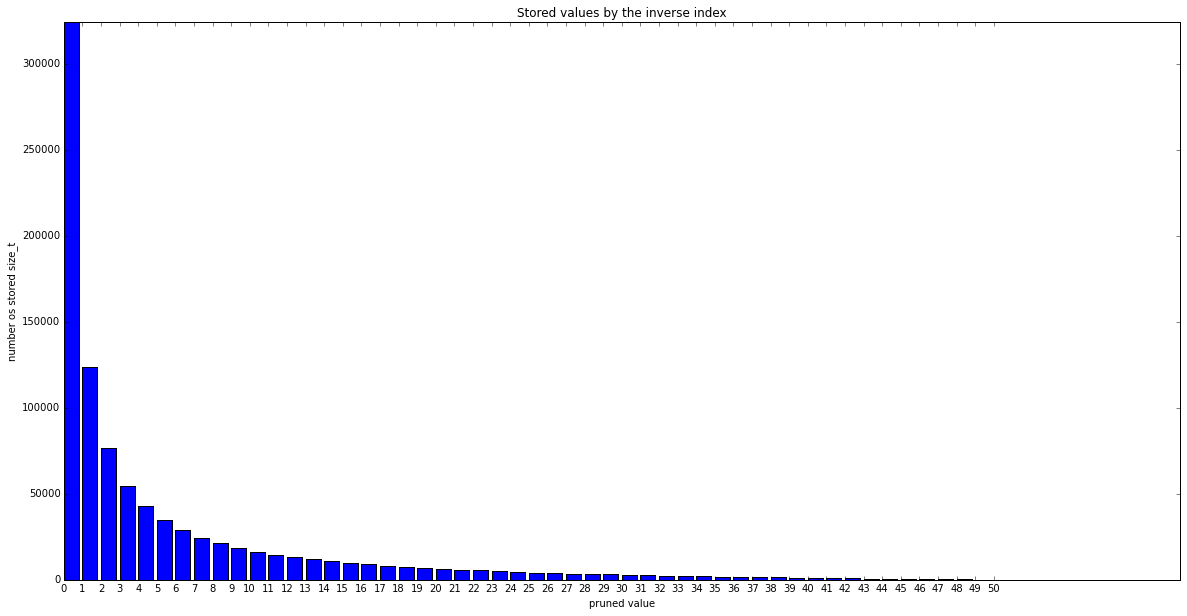

In [11]:
elements_in_index = []
for instance in distribution_inverse_index:
    value = 0
    for data in instance[0]:
        value += instance[0][data]
    elements_in_index.append(value)
print elements_in_index

data = np.arange(len(elements_in_index))
plt.figure(figsize=(20, 10))
plt.bar(data, elements_in_index)
plt.xticks(data, range(prune_value))
ymax = max(elements_in_index)
plt.ylim(0, ymax)
plt.ylabel("number os stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

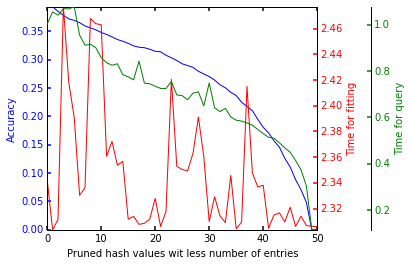

In [12]:
createPlot(range(prune_value), accuracy_, time_fit_, time_kneighbors_, "Pruned hash values wit less number of entries", "Accuracy",
           "Time for fitting", "Time for query")

In [6]:
min_value = min(distribution[1])
max_value = max(distribution[1])
n_neighbors_sklearn = NearestNeighbors()
n_neighbors_sklearn.fit(datasetBursi)
neighbors_sklearn = n_neighbors_sklearn.kneighbors(return_distance=False)
accuracy = []
time_fit = []
time_kneighbors = []

distribution_inverse_index = []
for value in sorted(distribution[1]):
    n_neighbors_minHash_prune = MinHash(number_of_hash_functions=400, shingle_size = 1, similarity=True, 
                                        bloomierFilter=False, number_of_cores=2, 
                                        prune_inverse_index=-1, prune_inverse_index_after_instance=-1,
                                        removeHashFunctionWithLessEntriesAs=value)
    time_start = time.time()
    n_neighbors_minHash_prune.fit(datasetBursi)
    distribution_inverse_index.append(n_neighbors_minHash_prune.get_distribution_of_inverse_index())
    time_end = time.time() - time_start
    time_fit.append(time_end)
    time_start = time.time()
    neighbors = n_neighbors_minHash_prune.kneighbors(return_distance=False, fast=False)
    time_end = time.time() - time_start
    time_kneighbors.append(time_end)
    accuracy_value = 0
    for x, y in zip(neighbors, neighbors_sklearn):
        accuracy_value += accuracy_score(x, y)
    accuracy.append(accuracy_value / len(neighbors))

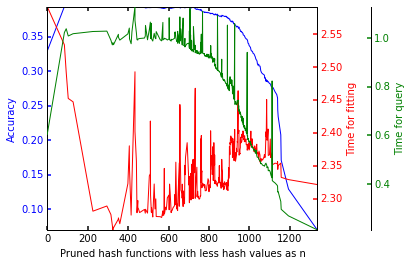

In [9]:
createPlot(sorted(distribution[1]), accuracy, time_fit, time_kneighbors, "Pruned hash functions with less hash values as n",
           "Accuracy", "Time for fitting", "Time for query")

[58413, 322491, 318728, 314205, 309148, 303699, 298408, 291596, 285124, 278449, 272950, 266593, 257952, 249805, 242974, 235307, 226689, 218702, 211421, 204042, 194076, 185628, 177038, 168310, 160336, 151390, 141460, 132311, 123085, 113775, 104329, 94785, 85136, 75364, 66443, 55367, 45068, 34563, 23801, 12778, 1335]
Mean:  808


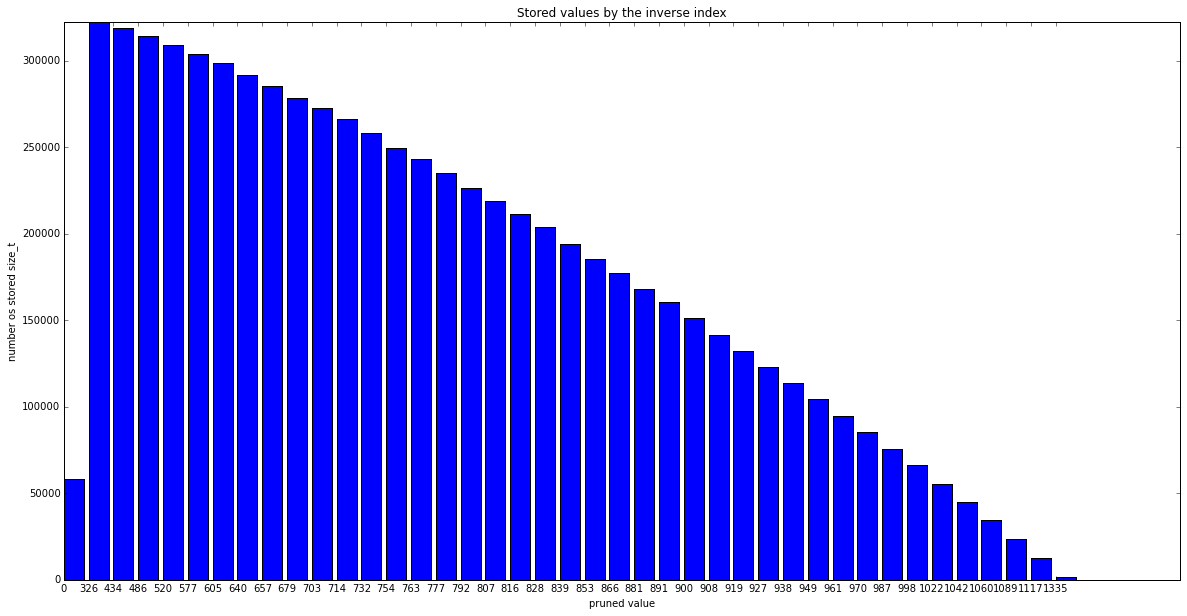

In [36]:
elements_in_index = []
for instance in distribution_inverse_index[0::10]:
    value = 0
    for data in instance[0]:
        value += instance[0][data]
    elements_in_index.append(value)
print elements_in_index

mean = 0
for i in sorted(distribution[1]):
    mean += i
print "Mean: ", mean / len(distribution[1])
data = np.arange(len(elements_in_index))
plt.figure(figsize=(20, 10))
plt.bar(data, elements_in_index)
plt.xticks(data, sorted(distribution[1])[0::10])
ymax = max(elements_in_index)
plt.ylim(0, ymax)
plt.ylabel("number os stored size_t")
plt.xlabel("pruned value")
plt.title("Stored values by the inverse index")
plt.show()

In [ ]:
print "std: ", distribution[5]